# Regression Model to predict `nummosquitos`

After adding the feature `nummosquitos` to our model, we saw a substantial improvement in our model. As such we felt that it was important for us to add this feature to our final model. The only we can do that is if we predict the feature for our Kaggle test dataset. In this notebook, we will conduct feature selection and test a few models to find the best performing one and use that to predict the feature for the kaggle test dataset.

## Table of contents
1. [All Imports](#All-Imports)
2. [Feature Selection](#Feature-Selection)
3. [Dummification](#Dummification)
4. [Modeling](#Modeling)
    - [Defining X and y](#Defining-X-and-y)
    - [Model Training](#Model-Training)</p>
5. [Getting test data ready](#Getting-test-data-ready)
6. [Getting required predictions](#Getting-required-predictions)

## All Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

We will start with our merged dataset, **BEFORE** we did feature engineering. This is because the previously done feature engineering was meant for our target `wnvpresent`. This time, our target will be `nummosquitos`.

In [2]:
# reading in our merged dataset, before feature engineering
df_merged = pd.read_csv('../data/weather_train_merged.csv')

---

## Feature Selection

In [3]:
# checking the correlation score of numerical features
num_feats_corr = abs(df_merged.drop(columns=['wnvpresent'])\
                     .corr()['nummosquitos'])\
                     .sort_values(ascending=False)

num_feats_corr.index

Index(['nummosquitos', 'tavg', 'tmin', 'wetbulb', 'year', 'cool', 'tmax',
       'dewpoint', 'heat', 'longitude', 'addressaccuracy', 'station',
       'latitude', 'block', 'week', 'avgspeed', 'month', 'stnpressure',
       'resultspeed', 'weekday', 'sealevel', 'preciptotal', 'resultdir'],
      dtype='object')

Before we make any conclusions about the features, let's take a look at the heatmap as well.

In [4]:
# custom function to plot heatmap

def plot_heatmap(df):
    """Function accepts a DataFrame as an input. 
    It returns the 'lower triangle' of the heatmap
    from seaborn."""
    
    # defining figure size
    plt.figure(figsize=(22,22))

    # creating mask to display only lower half of
    # heatmap as per the sns documentation.
    mask = np.zeros_like(df.corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # plotting the heatmap with following params
    sns.heatmap(df.corr(), mask=mask, annot=True, 
                annot_kws={'size': 13}, cmap='coolwarm', 
                vmin=-1, vmax=1, square=True, fmt='.1g', 
                cbar_kws={'shrink':0.8}, center=0);

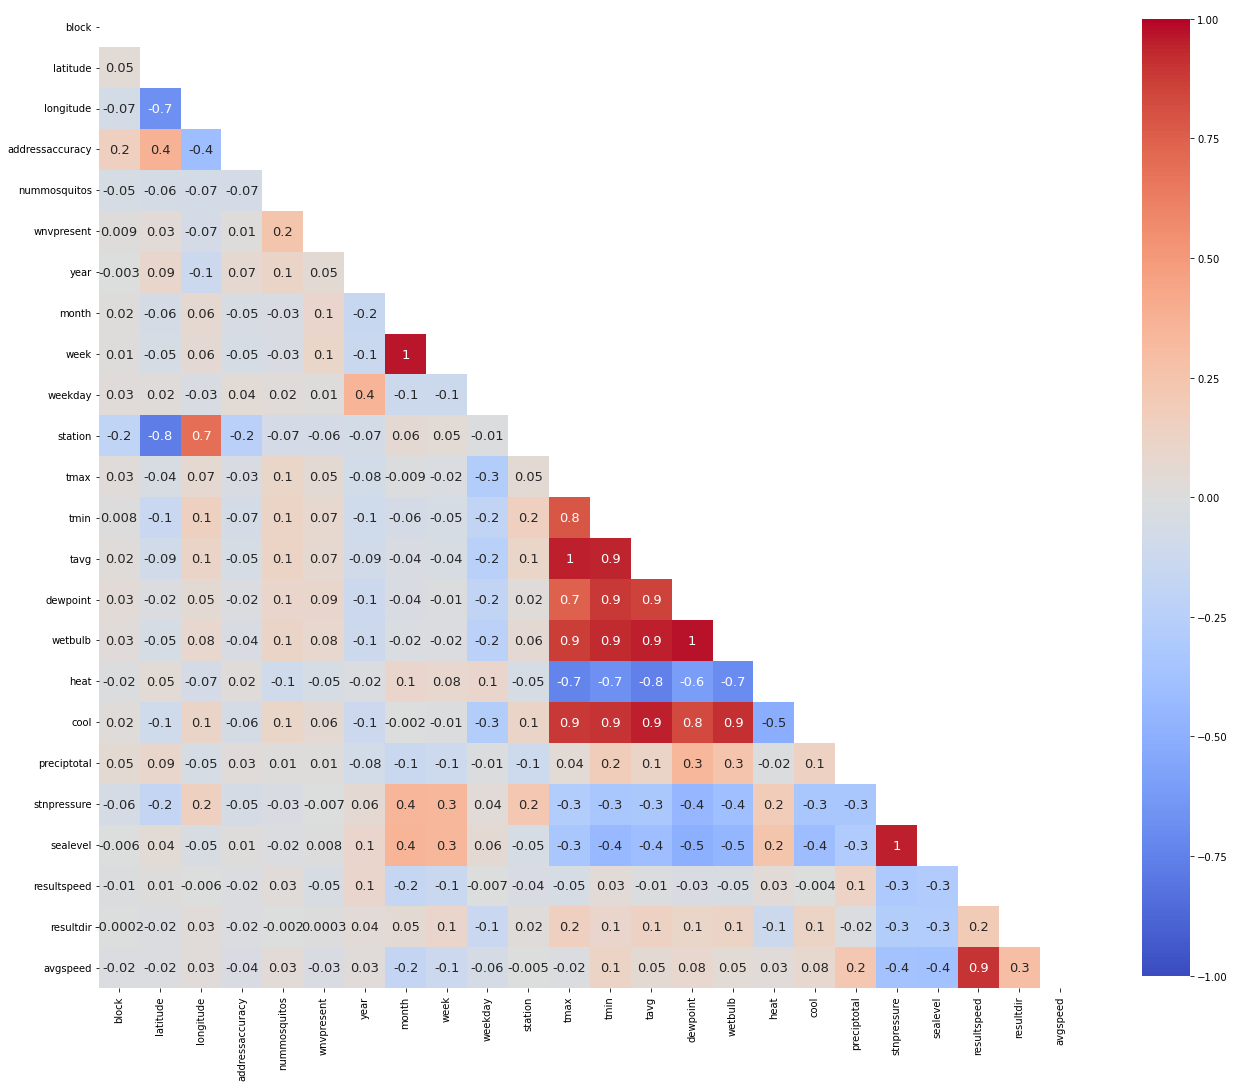

In [5]:
# plotting heatmap for our merged DataFrame
plot_heatmap(df_merged)

To keep things simple, we will drop any features with correlation lesser than 1% with our target `nummosquitos`. <br>
Additionally, to minimize multi-collinearity and/or pairwise correlation, we will also drop the following features:
* `resultdir` *(correlation score below 1%)*
* `tmin`
* `tmax`
* `wetbulb`
* `cool`

Previously in the feature engineering notebook, we had dropped a couple of categorical and nominal features in our dataset to reduce potential multi-collinearity, e.g. dropping `address`, `latitude` and `longitude` in favor of `traps`. We will also repeat those drops here. Features we are choosing to drop are listed below:
* `address`, `addressaccuracy`, `addressnumberandstreet`, `street`, `latitude`, `longtitude` *(we will be using `traps` as our main location feature)*
* `year`, `date` *(as the kaggle test data has different dates and years, these two features would not be relevant)*
* `sunrise`, `sunset` *(we will be using `dewpoint` and `tavg` as our main indicators of heat and humidity)*

We will also drop `wnvpresent` as that is our overall target and we cannot use that as a feature to predict `nummosquitos`. 

In [6]:
# dropping columns as mentioned above, together with 'wnvpresent'
df_merged.drop(columns=['address', 'addressaccuracy', 
                        'addressnumberandstreet', 'street', 
                        'latitude', 'longitude', 'year', 
                        'date', 'sunrise', 'sunset', 'resultdir', 
                        'tmin', 'tmax', 'wetbulb', 'cool',
                        'wnvpresent'], inplace=True)

Now let's take a look at our resultant numerical features correlation with our target `nummosquitos`.

In [7]:
num_feats_corr = abs(df_merged.corr()['nummosquitos']).sort_values(ascending=False)
num_feats_corr

nummosquitos    1.000000
tavg            0.119683
dewpoint        0.100673
heat            0.100003
station         0.067780
block           0.051671
week            0.034597
avgspeed        0.034573
month           0.032994
stnpressure     0.031891
resultspeed     0.026337
weekday         0.023738
sealevel        0.021216
preciptotal     0.010826
Name: nummosquitos, dtype: float64

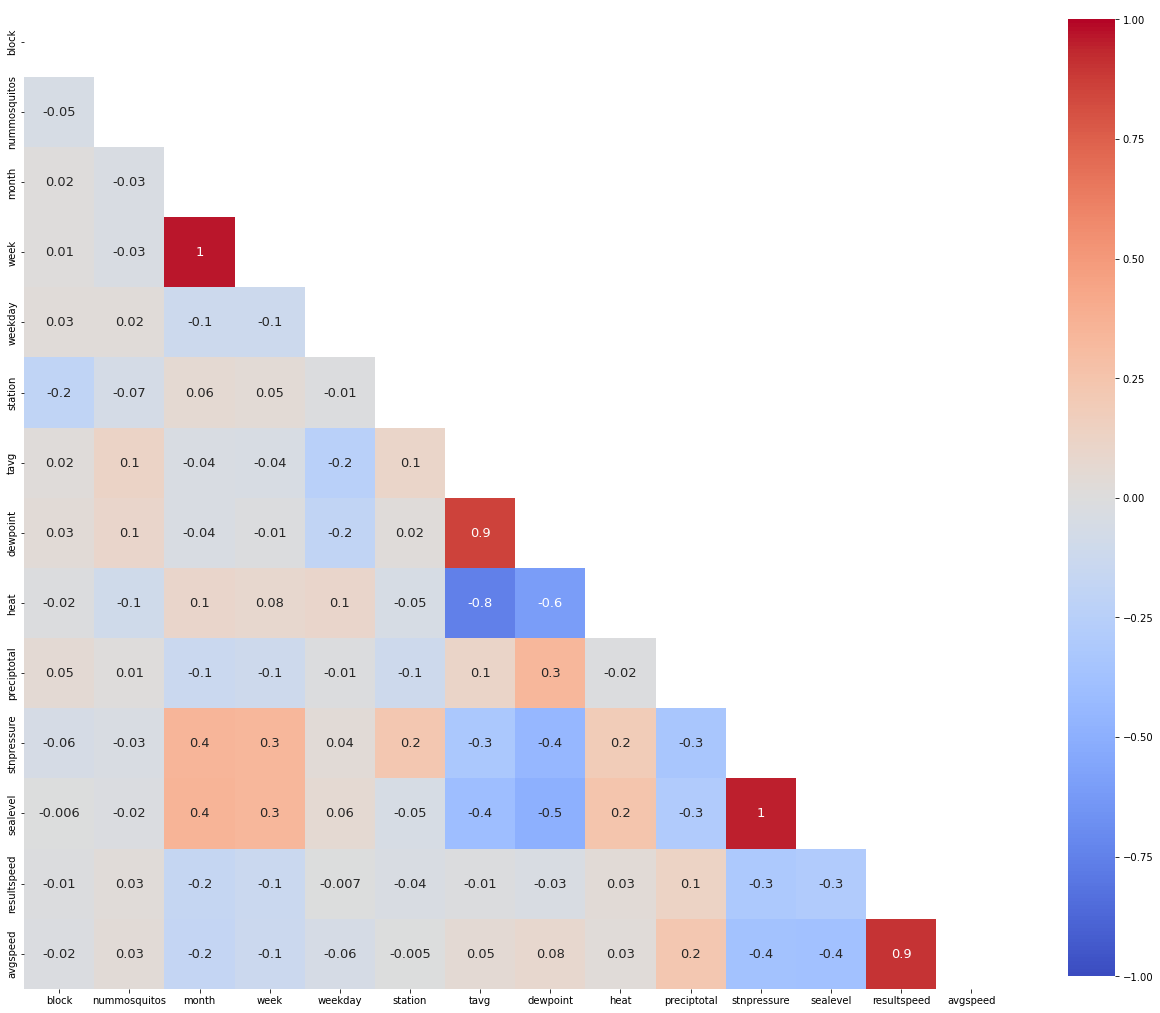

In [8]:
plot_heatmap(df_merged)

There is stil *some* multi-collinearity as can be seen from the above heatmap. However, let's test this out our model first before we think about solving that.

---

### Dummification

Before we start modeling, let's dummify a few features as given below:
* `month`, `week`, `weekday` (time features)
* `species`, `codesum`, `trap` (categorical features)

In [9]:
# dummifying said columns
df_merged = pd.get_dummies(
    df_merged,
    columns=['species', 'trap', 
             'month', 'week', 
             'weekday'], 
    drop_first=True
)

In order to dummify `codesum`, we will need to use `CountVectorizer`. 

In [10]:
# dummifying codesum and adding it in via countvec

# creating a new column for each weather condition
cvec = CountVectorizer()
cvec_df = pd.DataFrame(cvec.fit_transform(df_merged['codesum'])\
                       .todense(),
                       columns = cvec.get_feature_names_out())

# adding new columns into dataframe
df_merged = pd.concat([df_merged,cvec_df], axis=1)
df_merged.drop(['codesum'], axis=1, inplace=True)

Now we are ready to define our `X` and `y` and conduct some modeling.

---

## Modeling

### Defining X and y

In [11]:
# defining X and y
X = df_merged.drop(columns=['nummosquitos'])
y = df_merged['nummosquitos']

In [12]:
# train_test_split for modeling
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=42
)

In [13]:
# creating scaled X for consistency 
# across all models
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [14]:
# Instantiate models
models = {'lr': LinearRegression(),
          'ridge': Ridge(),
          'lasso': Lasso(),
          'enet': ElasticNet()
}

In [15]:
# Function to run model -- input model
def get_model_scores(model_name,
                     mod):
    
    """Function accepts following inputs:
    Name of model (str), model to be used (str), 
    model params(dict, optional), grid_seach(boolean, optional)
    If grid_search is True, then please also input the relevant 
    params for GridSearching
    """
    
    # empty dict for appending results
    results = {}
    
    # add model name to results
    results['model_name'] = model_name
    
    # instantiate model and fit
    reg_model = models[mod]
    reg_model.fit(X_train_sc, y_train)
    
    # get model predictions for train and test
    preds_train = reg_model.predict(X_train_sc)
    preds_test = reg_model.predict(X_test_sc)

    # get rmse score for train and test
    # getting both will allow us to check for overfit
    results['rmse_train'] = mean_squared_error(y_train, 
                                               preds_train, 
                                               squared=False)

    results['rmse_test'] = mean_squared_error(y_test, 
                                              preds_test, 
                                              squared=False)
    
    # add results to list for model evaluation later
    model_eval.append(results)
   
    # print statement to indicate model run successfully
    print('Fitted and scores saved.')
    return reg_model

In [16]:
# create list to store results
model_eval =[]

### Model Training

In [17]:
lr_base = get_model_scores('lr_base', 'lr')
ridge_base = get_model_scores('ridge_base', 'ridge')
lasso_base = get_model_scores('lasso_base', 'lasso')
enet_base = get_model_scores('enet_base', 'enet')

Fitted and scores saved.
Fitted and scores saved.
Fitted and scores saved.
Fitted and scores saved.


In [18]:
base_model_scores = pd.DataFrame(model_eval)
base_model_scores.sort_values('rmse_test')

,model_name,rmse_train,rmse_test
0,lr_base,11.300105,11.291494
1,ridge_base,11.300194,11.291883
3,enet_base,12.400788,12.430546
2,lasso_base,12.696070,12.753713


Based on the root mean-squared-error of the train and the test, we can surmise that the model is not overfit or underfit on our dataset.
<br>
We can also see that our `LinearRegression` model is the best of all. We will use this model to predict the values in our test dataset in order for us to then predict `wnvpresent` on the new test dataset with predicted `nummosquito` values.

---

### Getting test data ready

We will now create a function to first replicate the actions we took on the dataset in order for us to predict the `nummosquitos` for our kaggle test dataset.

In [19]:
def replicate_steps(train_df, test_df):
    df = test_df
    train_df = train_df
    
    # dropping columns as mentioned above, together with 'wnvpresent'
    df.drop(columns=['address', 'addressaccuracy', 
                        'addressnumberandstreet', 'street', 
                        'latitude', 'longitude', 'year', 
                        'date', 'sunrise', 'sunset', 'resultdir', 
                        'tmin', 'tmax', 'wetbulb', 'cool'], inplace=True)
    
    df = pd.get_dummies(df, columns=['species', 'trap', 'month', 'week', 'weekday'], drop_first=True)
    
    cvec = CountVectorizer()
    cvec_df = pd.DataFrame(cvec.fit_transform(df['codesum'])\
                           .todense(),
                           columns = cvec.get_feature_names_out())

    # adding new columns into dataframe
    df = pd.concat([df,cvec_df], axis=1)
    df.drop(['codesum'], axis=1, inplace=True)
    
    # ensuring all columns are the same between train and test DataFrames
    df_col = df.columns
    train_col = train_df.columns    
    
    additional_cols = [col for col in df_col if col not in train_col]
    df.drop(columns=additional_cols, inplace=True)
    
    missing_cols = [col for col in train_col if col not in df_col and col != 'nummosquitos']
    
    # for loop to create missing columns in test dataset
    for col in missing_cols:
        df[col] = 0
    
    
    return df

In [20]:
# reading in the test data
df_test = pd.read_csv('../data/weather_test_merged.csv')

In [21]:
# replicating the changes we made to 
# our original merged dataframe
df_test = replicate_steps(df_merged, df_test)

---

### Getting required predictions

Now we are ready to create our final model to predict the `nummosquitos` in our kaggle test dataset. Before we do the final model, we will reorder our columns in ascending order to ensure that all columns in our train and test dataset are in the same order.

In [22]:
# setting our train columns to be sorted
train_cols = df_merged.columns.tolist()
train_cols.sort()
df_merged = df_merged[train_cols]

In [23]:
# setting our test columns to be sorted
test_cols = df_test.columns.tolist()
test_cols.sort()
df_test = df_test[test_cols]

In [24]:
# redefining X and y for our model
X = df_merged.drop(columns=['nummosquitos'])
y = df_merged['nummosquitos']

# creating scaled X for model
ss = StandardScaler()
X_sc = ss.fit_transform(X)

In [25]:
# instantiate model
lr_final = LinearRegression()

lr_final.fit(X, y)

LinearRegression()

In [26]:
# defining our X_test
X_test = df_test

In [27]:
# creating the predictions
nummosquitos_preds = lr_final.predict(X_test)

In [28]:
# creating our mosquito predictions
nummosquitos_preds = pd.DataFrame(nummosquitos_preds,
                                 columns=['nummosquitos'])

In [29]:
# saving both our train and test dataframes in case we need 
# to access them later
df_merged.to_csv('../data/train_linear_model.csv', index=False)
df_test.to_csv('../data/test_linear_model.csv', index=False)

Looking at our predictions we see that there are a few predictions that are negative. In order for the numbers to make sense, we will map those values to zero as it is not possible to have *negative* `nummosquitos`.

In [30]:
# changing all negative nummosquito values to zero
nummosquitos_preds['nummosquitos'] = nummosquitos_preds['nummosquitos'].map(lambda x: 0 if x < 0 else x)

In [31]:
# saving our predicted nummosquitos to file
nummosquitos_preds.to_csv('../data/nummosquitos_preds.csv', index=False)

Now we are ready to use these figures as part of our Kaggle submission.